# Baseline correction of spectra

In this notebook notebook, I will demonstrate a simple method for baseline correction of spectra using the Whittaker smoother. The method used in this notebook should have a broader applicability but was implemented with NMR (nuclear magnetic resonance) spectra in mind.

This notebook picks up ideas from following publications:
- Eilers, A Perfect Smoother. *Anal. Chem.* **2003**, *75*, 3631-3636.
- Golotvin and Williams, Improved Baseline Recognition and Modeling of FT NMR Spectra. *J. Magn. Res.* **2000**, *146*, 122–125.
- Zorin, Bernstein, and Cobas, A robust, general automatic phase correction algorithm for high-resolution NMR data. *Magn. Reson. Chem.* **2017**, *55*, 738–746.

First, we will create an artifical spectrum by adding some noise and a baseline to two Lorentz signals:

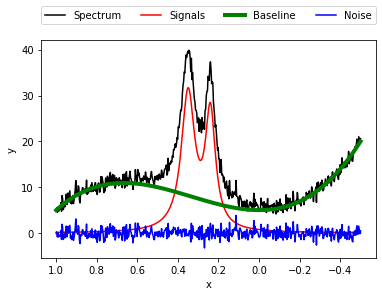

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def lorentz(a, c, w, x):
    y = a * (1 / (1 +((x - c) / (0.5 * w))**2))
    return y


x = np.linspace(-0.5, 1, 512)
np.random.seed(42)
sp_noise = np.random.normal(0, 1, size=len(x))
sp_baseline = (-x**3 + x**2) * 40 + 5
sp_signals = lorentz(25, 0.24, 0.06, x) + lorentz(30, 0.35, 0.08, x)
y = sp_noise + sp_baseline + sp_signals

fig, ax = plt.subplots()
ax.plot(x, y, color="k", label="Spectrum")
ax.plot(x, sp_signals, color="r", label="Signals")
ax.plot(x, sp_baseline, color="g", lw="4", label="Baseline")
ax.plot(x, sp_noise, color="b", label="Noise")
ax.invert_xaxis()
plt.xlabel("x"), plt.ylabel("y")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=4)
plt.show()

Subsequent mapping of the spectrum into signal and baseline regions is performed on the 1st derivative of the spectrum. For this, we will be using the smooth noise-robust differentiation proposed by Holoborodko:
- Holoborodko, Smooth noise robust differentiators. Online: http://www.holoborodko.com/pavel/numerical-methods/numerical-derivative/smooth-low-noise-differentiators/

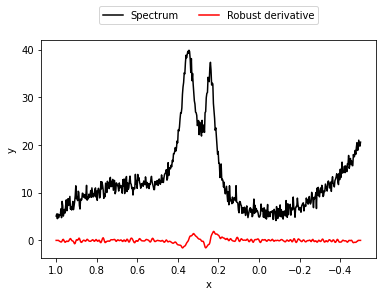

In [2]:
def robust_derivative(y):
    window = np.lib.stride_tricks.\
             sliding_window_view(y, window_shape=len(y)-10)
    d = (42 * (window[6] - window[4]) + 48 * (window[7] - window[3]) + 27 *
     (window[8] - window[2]) + 8 * (window[9] - window[1]) + window[10] -
      window[0]) / 512
    d = np.pad(d, pad_width=(5, 5), mode="constant", constant_values=0)
    return d

d = robust_derivative(y)

fig, ax = plt.subplots()
ax.plot(x, y, color="k", label="Spectrum")
ax.plot(x, d, color="r", label="Robust derivative")
ax.invert_xaxis()
plt.xlabel("x"), plt.ylabel("y")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=4)
plt.show()

Now we will use this robust derivative to map the spectrum into signal and baseline regions. The method slides a window over the robust derivative and calculates the difference between the maximum and minimum signal intensity within this window. If this difference is 3x (=default cut-off) larger than the smallest value found amongst all windows, the data point in the center of the window is deemed to be a signal data point. The window width *n* can be adjusted to accomodate broader or narrower signal regions.

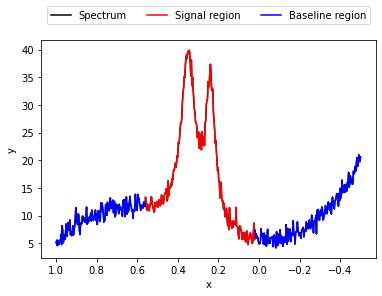

In [3]:
from textwrap import dedent

def map_baseline(y, d, n, cutoff=3):
    if n % 2 == 0:
        n = n + 1
    if n * 2 + 1 >= len(y) * 0.8:
        print(dedent("""
        The sliding window takes up more than 80% of the spectrum.
        Please consider a more reasonable window width."""))
        
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=n)
    maxs = np.pad(np.amax(windows, axis=1), pad_width=(n // 2, n // 2), constant_values=0)
    mins = np.pad(np.amin(windows, axis=1), pad_width=(n // 2, n // 2), constant_values=0)
    diffs = maxs - mins
    diffs_min = min(diffs[(n//2):-(n//2)])    

    baseline, signal = y.copy(), y.copy()
    baseline[abs(diffs) > cutoff * diffs_min] = np.nan
    signal[abs(diffs) < cutoff * diffs_min] = np.nan
    weights = np.where(abs(diffs) < (cutoff * diffs_min), 1, 0)
    return baseline, signal, weights


baseline, signal, weights = map_baseline(y, d, n=151)

fig, ax = plt.subplots()
ax.plot(x, y, color="k", label="Spectrum")
ax.plot(x, signal, color="r", label="Signal region")
ax.plot(x, baseline, color="b", label="Baseline region")
ax.invert_xaxis()
plt.xlabel("x"), plt.ylabel("y")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=4)
plt.show()

Now we will perform baseline correction using the Whittaker smoother. To achieve baseline correction we will feed the weights vector calculated above to the Whittaker function. In this weight vector, all signal data points have zero weight (and baseline data points have a weight of one).

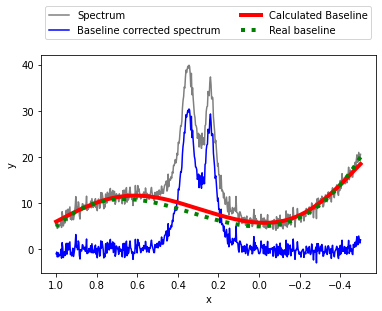

In [5]:
from scipy import sparse
from scipy.sparse.linalg import splu

def whittaker(y, d=1, lmbda=1, **kwargs):
    w = kwargs.get("w", np.ones(len(y)))
    m = len(y)
    D = sparse.eye(m, format="csc")
    for i in range(d): D = D[1:] - D[:-1]
    W = sparse.spdiags(w, 0, m, m, format="csc")
    z = splu(W + lmbda * D.T * D).solve((y*w))
    return z


baseline = whittaker(y, d=2, lmbda=10**6, w=weights)
y_corrected = y - baseline

fig, ax = plt.subplots()
ax.plot(x, y, color="k", label="Spectrum", alpha=0.5)
ax.plot(x, y_corrected, color="b", label="Baseline corrected spectrum")
ax.plot(x, baseline, color="r", lw="4", label="Calculated Baseline")
ax.plot(x, sp_baseline, color="g", lw="4", linestyle = ":", label="Real baseline")
ax.invert_xaxis()
plt.xlabel("x"), plt.ylabel("y")
ax.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=2)
plt.show()

We can see that the calculated baseline comes quite close to the actual baseline.